In [1]:
%matplotlib notebook

# lib import
import numpy as np
import scipy.spatial as ssp
import matplotlib.pyplot as plt
from time import sleep
import math
N_CENTERS = 5
N_POISON = 10
N_POINTS = 100

In [2]:
def get_furthest_vertex(vertices, points): 
    glob_diffs = []
    for i in range(len(vertices)): 
        diffs = []
        for j in range(len(points)): 
            cur_vertex = vertices[i]

            if cur_vertex[0] > 0 and cur_vertex[0] < 1 and cur_vertex[1] > 0 and cur_vertex[1] < 1: 
                diffs.append(np.linalg.norm(vertices[i] - points[j]))
            else: 
                diffs.append(0)
                
        max_idx = np.argmax(diffs)
        glob_diffs.append(diffs[max_idx])
    max_distance_vertex = vertices[np.argmax(glob_diffs)]
    print(f"Selected vertex is = {max_distance_vertex}")
    return max_distance_vertex

## Code for gonzalez algo comes from here: [next 3 functions]
## https://www.kaggle.com/barelydedicated/gonzalez-algorithm
def calculate_cost(data_set, cluster_points): 
    cluster_distance = np.full(len(data_set), np.inf)
    for point_idx, point in enumerate(data_set):
        for cluster_idx, cluster_point in enumerate(cluster_points):
            if cluster_distance[point_idx] is math.inf:
                cluster_distance[point_idx] = np.linalg.norm(point-cluster_point)
                continue
            if np.linalg.norm(point-cluster_point) < cluster_distance[point_idx]:
                cluster_distance[point_idx] = np.linalg.norm(point-cluster_point)
    return np.max(cluster_distance)

def gonzalez(ds, cluster_num):
    C = []
    # First point is arbitrary
    C.append(ds[np.random.randint(0, len(ds))]) 
    #C.append(ds[0]) 
    for _ in range(cluster_num):
        C.append(max_dist(ds, C)) 
        
    return C

def max_dist(data, clusters):
    distances = np.zeros(len(data)) # we will keep a cumulative distance measure for all points
    for cluster_id, cluster in enumerate(clusters):
        for point_id, point in enumerate(data):
            if np.linalg.norm(point-cluster) == 0.0:
                distances[point_id] = -math.inf # this point is already a cluster (obselete)
            if not math.isinf(distances[point_id]):
                # if a point is not obselete, then we add the distance to its specific bin
                distances[point_id] = distances[point_id] + np.linalg.norm(point-cluster) 
                # return the point which is furthest away from all the other clusters
    return data[np.argmax(distances)]

<IPython.core.display.Javascript object>


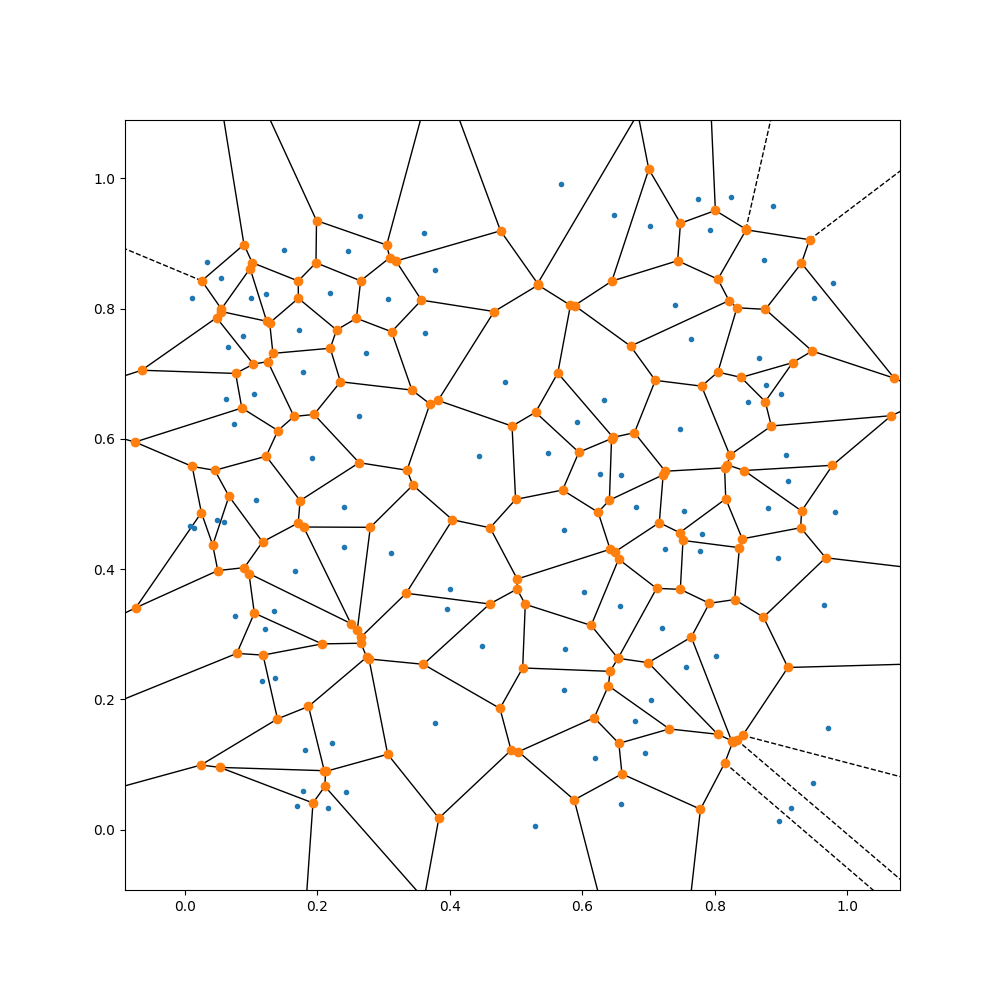

In [3]:
ffg, aax = plt.subplots(1, 1,figsize=(10, 10))

points = np.random.rand(N_POINTS, 2)
boundaries = np.array([[0, 0], [0, 1], [1, 1], [1, 0]]).reshape(4, 2)
#points = np.concatenate((points, boundaries))
voronoi_diagram = ssp.Voronoi(points, incremental=True)
orig_diag       = ssp.Voronoi(points, incremental=True)
ssp.voronoi_plot_2d(voronoi_diagram, ax=aax)
plt.show()

<IPython.core.display.Javascript object>


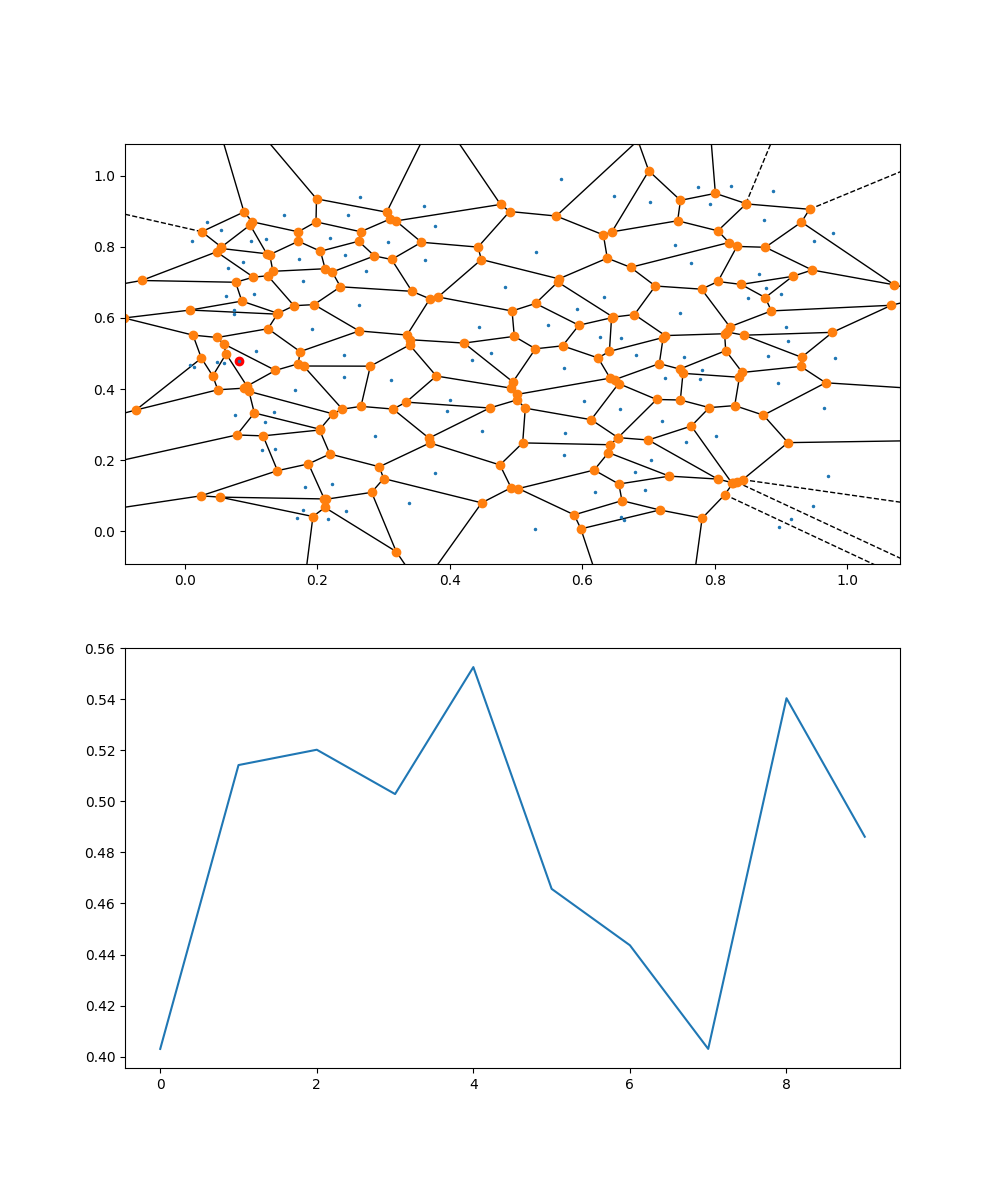

Baseline cost is 0.4029867567598493


In [4]:
fig, (ax, ax_cost) = plt.subplots(2,1,figsize=(10, 12))
c = gonzalez(points, N_CENTERS)
baseline = calculate_cost(points, c)
print(f"Baseline cost is {baseline}")
cost_random = [baseline]
for _ in range(N_POISON - 1):
    ax.clear()
    ax_cost.clear()
    new_point = np.random.rand(1, 2)
    voronoi_diagram.add_points(new_point)
    c = gonzalez(voronoi_diagram.points, N_CENTERS)
    cost_random.append(calculate_cost(points, c))
    #print(f"New cost is {cost_random[-1]}")
    ax.plot([new_point[0, 0]], [new_point[0, 1]], "ro")
    ax_cost.plot([i for i in range(N_POISON)],[*cost_random, *[0 for _ in range(N_POISON - len(cost_random))]])
    ssp.voronoi_plot_2d(voronoi_diagram, ax=ax, point_size=3)
    #plt.xlim((-1, 1))
    #plt.ylim((-1, 1))
    fig.canvas.draw()
    sleep(.5)

In [5]:
print(f"Cost trace = {cost_random}")

Cost trace = [0.4029867567598493, 0.5142716490874706, 0.520285430039373, 0.5029056005659533, 0.5526851596703524, 0.4657361478188107, 0.44361361123927384, 0.4029867567598493, 0.5404714216621604, 0.4861783527290746]


<IPython.core.display.Javascript object>


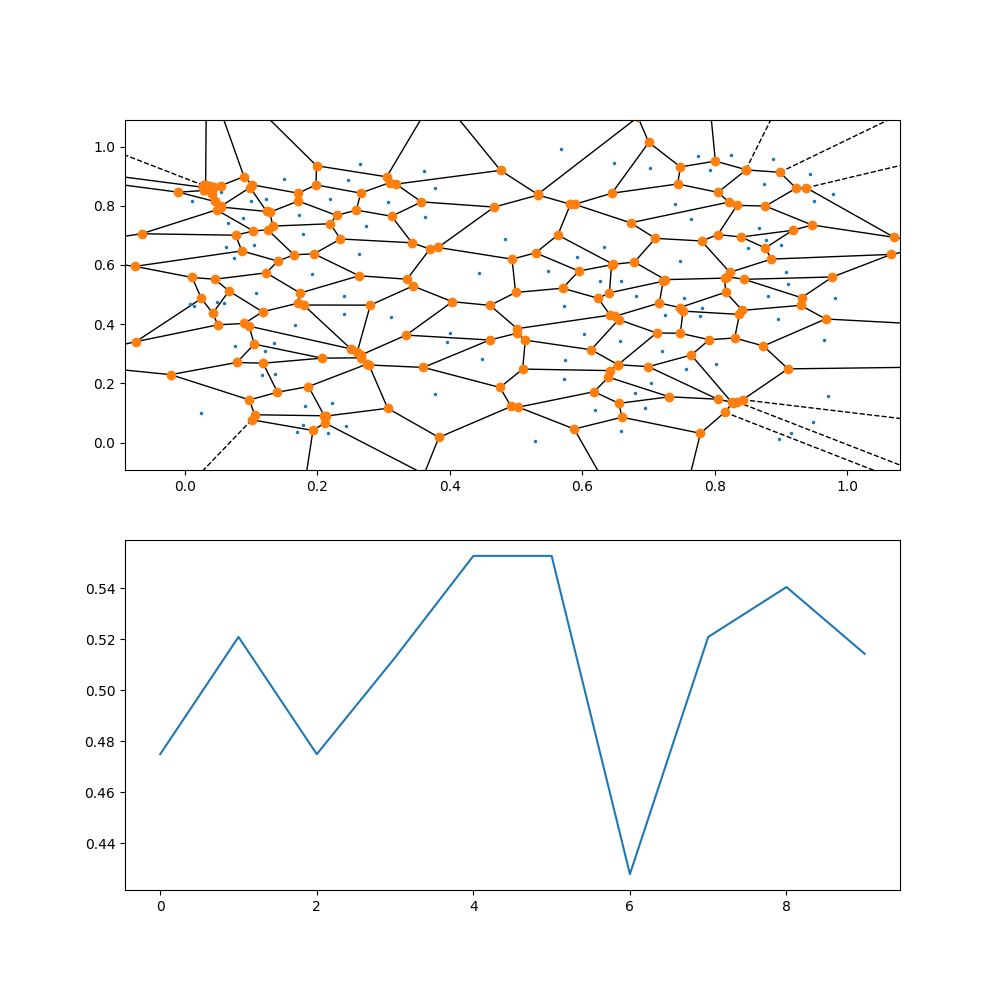

Baseline cost is 0.4749636261485279
Adding vertices from Voronoi Diagram
Selected vertex is = [0.02444595 0.09932499]
Selected vertex is = [0.94318026 0.90587372]
Selected vertex is = [0.02572575 0.842785  ]
Selected vertex is = [0.03902048 0.85439471]
Selected vertex is = [0.02332002 0.85895691]
Selected vertex is = [0.0326329  0.86170939]
Selected vertex is = [0.02583011 0.86759521]
Selected vertex is = [0.0311185  0.86683327]
Selected vertex is = [0.02906845 0.87133806]
Cost trace = [0.4749636261485279, 0.5209072994521444, 0.4749636261485279, 0.5128504611928593, 0.5526851596703524, 0.5526851596703524, 0.4279466489656534, 0.5209072994521444, 0.5404714216621604, 0.5142716490874706]


In [6]:
fig, (ax, ax_cost) = plt.subplots(2,1,figsize=(10, 10))

vertices = orig_diag.vertices
points   = orig_diag.points
c = gonzalez(points, N_CENTERS)
baseline = calculate_cost(points, c)
print(f"Baseline cost is {baseline}")
cost_anti_gonzalez = [baseline]
print("Adding vertices from Voronoi Diagram")

for _ in range(N_POISON - 1): 
    vertex = get_furthest_vertex(vertices, points).reshape(1,  2)
    ax.clear()
    ax_cost.clear()
    new_point = vertex
    orig_diag.add_points(new_point)
    c = gonzalez(voronoi_diagram.points, N_CENTERS)
    cost_anti_gonzalez.append(calculate_cost(points, c))
    ax.plot([new_point[0, 0]], [new_point[0, 1]], "ro")
    ax_cost.plot([i for i in range(N_POISON)],[*cost_anti_gonzalez, *[0 for _ in range(N_POISON - len(cost_anti_gonzalez))]])
    ssp.voronoi_plot_2d(orig_diag, ax=ax, point_size=3)
    #plt.xlim((-1, 1))
    #plt.ylim((-1, 1))
    fig.canvas.draw()
    sleep(.5)
    vertices = orig_diag.vertices
    points = orig_diag.points
    
print(f"Cost trace = {cost_anti_gonzalez}")